# Simple gender analysis

- ## Imports

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import unicodedata

import os, sys, json, re, argparse, urllib2, html5lib
from bs4 import BeautifulSoup, Tag, UnicodeDammit
import pandas as pd
from pandas.io.json import json_normalize
import time
import math
from parse_script import *


/home/duc-vinh/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


- ### Extract functions

- ### Script loader and parser

In [2]:
actions=['http://www.imsdb.com/scripts/2012.html','http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html',
      'http://www.imsdb.com/scripts/V-for-Vendetta.html','http://www.imsdb.com/scripts/Above-the-Law.html',
        'http://www.imsdb.com/scripts/Alien-3.html','http://www.imsdb.com/scripts/Blade-Runner.html',
        'http://www.imsdb.com/scripts/G.I.-Joe-The-Rise-of-Cobra.html','http://www.imsdb.com/scripts/Godzilla.html',
        'http://www.imsdb.com/scripts/Gladiator.html','http://www.imsdb.com/scripts/Lord-of-the-Rings-Return-of-the-King.html']
output=[]

for url in actions:
    path='../data/script/'
    name=url.replace(':','').replace('/','')
    test=parse(url,path,name)
    output.append(test)

('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/2012.html.
      Done parsing script at http://www.imsdb.com/scripts/2012.html in 1.98320508003
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html.
      Done parsing script at http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html in 1.38598299026
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/V-for-Vendetta.html.
      Done parsing script at http://www.imsdb.com/scripts/V-for-Vendetta.html in 1.72251605988
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Above-the-Law.html.
This script is too unstable to parse
      Done parsing script at http://www.imsdb.com/scripts/Above-the-Law.html in 1.46992897987
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.

In [3]:
def clean_character(char):
    if isinstance(char,unicode) or isinstance(char,str):
        char=char.replace('\n','').replace('*','').replace('O/S','').replace('V.O.','')
        char=re.sub(' +',' ',char)
        if 'CONTINUED' in char:
            return u'CONTINUED'
        if '(' in char or ')' in char:
            regex = re.compile(".*?\((.*?)\)")
            to_delete = re.findall(regex, char)
            for e in to_delete:
                char=char.replace('(%s)' %e,'')
            if char=='' or ')'in char:
                return None
            else:
                return char.rstrip() #delete lose end white space
        else:
            return char.rstrip()
    else:
        return None
    
def continued_speech(char_vector):
    char_vector=list(char_vector)
    while 'CONTINUED' in char_vector:
        count=0
        idx=char_vector.index("CONTINUED")
        for element in char_vector[idx-1::-1]:
            #if (isinstance(element,str) or isinstance(element,unicode)) and (element!='unknown'):
            if element and element!='unknown':
                char_vector[idx]=char_vector[idx-1-count]
                #print('Replaces CONTINUED with %s' %(char_vector[idx-1-count]))
                break
            count=count+1   
    return char_vector


# to remove outliers
def principal_characters(char_dic):
    mean = 0
    for i, j in char_dic.items():
        mean = mean + j
    mean = mean / len(char_dic)

    stddev = 0
    for i, j in char_dic.items():
        stddev = stddev + (j - mean)*(j - mean)
    stddev = stddev / len(char_dic)
    stddev = math.sqrt(stddev)

    temp = {}
    for i, j in char_dic.items():
        if (math.fabs(j - mean) < 3*stddev):
            temp[i] = j
    print(stddev,mean)
    return temp


def char_analysis(df):
    d=dict(Counter(df['character_clean']))
    d={key: value for key, value in d.items() 
                 if key}
    charlist = sorted(d)
    gender = dict()
    lines=[element.split('\n') for element in output[1]['text']]
    lines=[item for sublist in lines for item in sublist]

    for char in charlist:
        m, f, p = 0, 0, 0 
        for i in range(len(lines)):
            srch = re.search(char, lines[i], re.I)
            if not srch:
                continue
            if srch.group().isupper():
                continue
            else:
                k, k_range = -1, 2
                while k + i + 1 < len(lines):
                    k = k + 1
                    m = m + len(re.findall("\s+he", lines[k+i], re.I)) + len(re.findall("\s+him", lines[k+i], re.I))
                    f = f + len(re.findall("\s+she", lines[k+i], re.I)) + len(re.findall("\s+her", lines[k+i], re.I))
                    if lines[k+i].isupper():
                        break
                    if k >= k_range:
                        break
                k, k_range = -1, 4
                while k + i + 1 < len(lines):
                    k = k + 1
                    m1, m2, m3, m4 = re.search("\s+he", lines[k+i], re.I), re.search("\s+him", lines[k+i], re.I),\
                                    re.search("\s+she", lines[k+i], re.I), re.search("\s+her", lines[k+i], re.I)
                    if m1:
                        if m2:
                            mc = min(m1.span()[0], m2.span()[0])
                        else:
                            mc = m1.span()[0]
                    else:
                        mc = len(lines[k+i])
                    if m3:
                        if m4:
                            fc = min(m3.span()[0], m4.span()[0])
                        else:
                            fc = m3.span()[0]
                    else:
                        fc = len(lines[k+i])
                    if not(m1 or m2 or m3 or m4):
                        continue
                    else:
                        if (mc < fc):
                            p = p - 1
                        else:
                            p = p + 1
                        break
                    if lines[k+i].isupper():
                        break
                    if k >= k_range:
                        break
        gender[char] = m, f, p

    for char, g in gender.items():
        g_score = 2*g[1] - g[0] 
        g_sum = g[1]+g[0]
        g_score = g_score
        if (g_sum == 0.0) :#or (0 == 1):
            #print(char+" Undetermined ")
            gender[char] = "?" #0, 0, -1
        elif g_score > 0:
            #print(char+" Female "+str(g[0])+","+str(g[1])+","+str(g[2])+","+str(g_score))
            gender[char] = "F" #0, 0, 1
        else:
            #print(char+" Male", " ", str(g[0])+","+str(g[1])+","+str(g[2])+","+str(g_score))
            gender[char] = "M" #0, 0, 0
            
    return d,gender

In [4]:
#construct character info and add it to dataframe
output_=[]
male_nb_speech=[]
female_nb_speech=[]
for df in output:
    try:
        test=df['character'].apply(lambda x :clean_character(x))
        df['character_clean']=continued_speech(test)
        char,gender=char_analysis(df)
        output_.append(char)
        #create gender column in dataframe:
        df['gender']=[gender.get(item,item)  for item in list(df['character_clean'])]
        male_nb_speech.append(len(df[df['gender']=='M']))
        female_nb_speech.append(len(df[df['gender']=='F']))
    except Exception as e:
        print('Caught exception : %s' %e)
        

Caught exception : 'character'


In [5]:
output[1][105:180]

,character,text,type,character_clean,gender
105,NaN,CRASH! Rey's sack carrying her heavy FOUND OBJ...,stage direction,None,None
106,NaN,EXT. NIIMA OUTPOST - CLEANING TABLE - DAY,location,None,None
107,NaN,TIGHT ON REY'S HANDS as she SCRUBS CLEAN her d...,stage direction,None,None
108,NaN,INT. NIIMA TRADING STRUCTURE - DAY,location,None,None
109,NaN,Rey looks up to a SERVICE WINDOW: two feet abo...,stage direction,None,None
110,UNKAR,What you've brought me today is\nworth... Hmmm...,speech,UNKAR,F
111,NaN,"Though disappointed, Rey barely shows it. She ...",stage direction,None,None
112,NaN,EXT. NIIMA OUTPOST - DAY,location,None,None
113,NaN,The IMMENSE SETTING SUN against the FLAT TERRA...,stage direction,None,None
114,NaN,INT. REY'S DWELLING - DAY,location,None,None


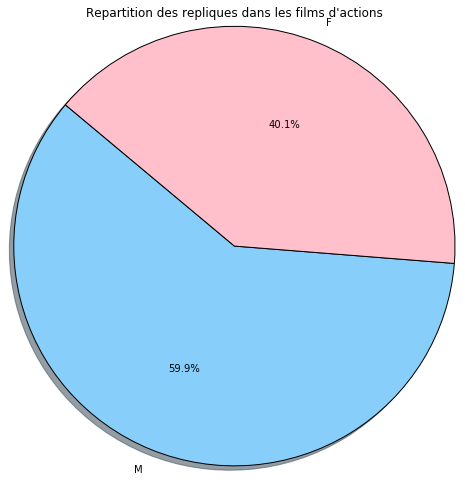

In [6]:
m=sum(male_nb_speech)
f=sum(female_nb_speech)

 
# Data to plot
labels = ["M","F"]
sizes = [m, f]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition des repliques dans les films d'actions") 
plt.axis('equal')
plt.show()

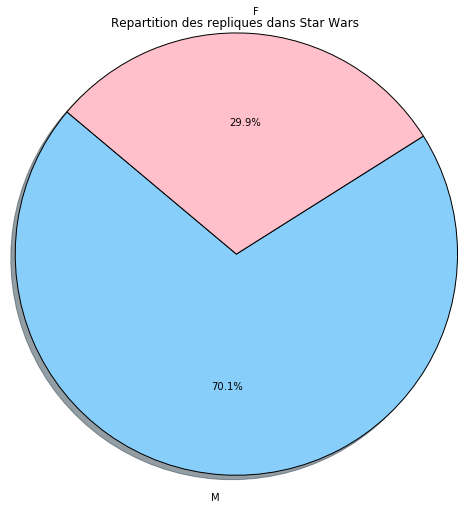

In [7]:
male_nb_speech=len(output[1][output[1]['gender']=='M'])
female_nb_speech=len(output[1][output[1]['gender']=='F'])

 
# Data to plot
labels = ["M","F"]
sizes = [male_nb_speech, female_nb_speech]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Repartition des repliques dans Star Wars') 
plt.axis('equal')
plt.show()

In [8]:
romance=['http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html','http://www.imsdb.com/scripts/Amour.html',
        'http://www.imsdb.com/scripts/Barry-Lyndon.html','http://www.imsdb.com/scripts/Color-of-Night.html',
        'http://www.imsdb.com/scripts/Date-Night.html','http://www.imsdb.com/scripts/Her.html',
        'http://www.imsdb.com/scripts/Kate-&-Leopold.html','http://www.imsdb.com/scripts/500-Days-of-Summer.html',
        'http://www.imsdb.com/scripts/Wild-At-Heart.html']
output=[]

for url in romance:
    path='../data/script/'
    name=url.replace(':','').replace('/','')
    test=parse(url,path,name)
    output.append(test)

('Detected encoding is ', u'iso-8859-1')
Found a <pre> inside the <pre>
Getting script @ http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html.
      Done parsing script at http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html in 1.68832588196
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Amour.html.
      Done parsing script at http://www.imsdb.com/scripts/Amour.html in 1.15828895569
-----------------
('Detected encoding is ', u'iso-8859-1')
Found a <pre> inside the <pre>
Getting script @ http://www.imsdb.com/scripts/Barry-Lyndon.html.
      Done parsing script at http://www.imsdb.com/scripts/Barry-Lyndon.html in 1.35054993629
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Color-of-Night.html.
      Done parsing script at http://www.imsdb.com/scripts/Color-of-Night.html in 1.48350310326
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting scr

In [9]:
#construct character info and add it to dataframe
output_=[]
male_nb_speech=[]
female_nb_speech=[]
for df in output:
    try:
        test=df['character'].apply(lambda x :clean_character(x))
        df['character_clean']=continued_speech(test)
        char,gender=char_analysis(df)
        output_.append(char)
        #create gender column in dataframe:
        df['gender']=[gender.get(item,item)  for item in list(df['character_clean'])]
        male_nb_speech.append(len(df[df['gender']=='M']))
        female_nb_speech.append(len(df[df['gender']=='F']))
    except Exception as e:
        print('Caught exception : %s' %e)
        

Caught exception : unbalanced parenthesis
Caught exception : unbalanced parenthesis


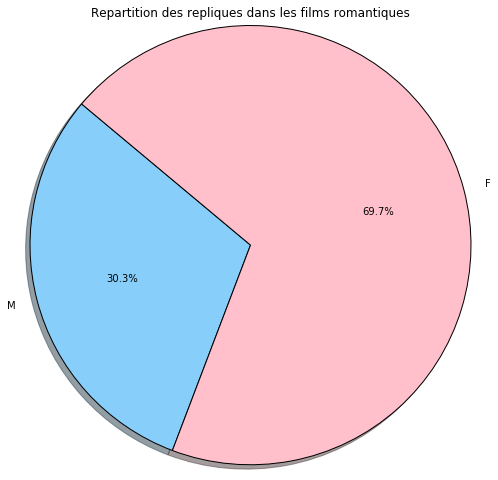

In [10]:
m=sum(male_nb_speech)
f=sum(female_nb_speech)

 
# Data to plot
labels = ["M","F"]
sizes = [m, f]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition des repliques dans les films romantiques") 
plt.axis('equal')
plt.show()

In [11]:
actions=['http://www.imsdb.com/scripts/2012.html','http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html',
      'http://www.imsdb.com/scripts/V-for-Vendetta.html','http://www.imsdb.com/scripts/Above-the-Law.html',
        'http://www.imsdb.com/scripts/Alien-3.html','http://www.imsdb.com/scripts/Blade-Runner.html',
        'http://www.imsdb.com/scripts/G.I.-Joe-The-Rise-of-Cobra.html','http://www.imsdb.com/scripts/Godzilla.html',
        'http://www.imsdb.com/scripts/Gladiator.html','http://www.imsdb.com/scripts/Lord-of-the-Rings-Return-of-the-King.html']
output_actions=[]

for url in actions:
    path='../data/script/'
    name=url.replace(':','').replace('/','')
    test=parse(url,path,name)
    output_actions.append(test)

('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/2012.html.
      Done parsing script at http://www.imsdb.com/scripts/2012.html in 1.7324988842
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html.
      Done parsing script at http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html in 1.45013189316
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/V-for-Vendetta.html.
      Done parsing script at http://www.imsdb.com/scripts/V-for-Vendetta.html in 1.57088398933
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Above-the-Law.html.
This script is too unstable to parse
      Done parsing script at http://www.imsdb.com/scripts/Above-the-Law.html in 1.45082402229
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.c

In [22]:
romance=['http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html','http://www.imsdb.com/scripts/Amour.html',
        'http://www.imsdb.com/scripts/Barry-Lyndon.html','http://www.imsdb.com/scripts/Color-of-Night.html',
        'http://www.imsdb.com/scripts/Date-Night.html','http://www.imsdb.com/scripts/Her.html',
        'http://www.imsdb.com/scripts/Kate-&-Leopold.html','http://www.imsdb.com/scripts/500-Days-of-Summer.html',
        'http://www.imsdb.com/scripts/Wild-At-Heart.html']
output_romances=[]

for url in romance:
    path='../data/script/'
    name=url.replace(':','').replace('/','')
    test=parse(url,path,name)
    output_romances.append(test)

('Detected encoding is ', u'iso-8859-1')
Found a <pre> inside the <pre>
Getting script @ http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html.
      Done parsing script at http://www.imsdb.com/scripts/10-Things-I-Hate-About-You.html in 2.87785315514
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Amour.html.
      Done parsing script at http://www.imsdb.com/scripts/Amour.html in 1.8778128624
-----------------
('Detected encoding is ', u'iso-8859-1')
Found a <pre> inside the <pre>
Getting script @ http://www.imsdb.com/scripts/Barry-Lyndon.html.
      Done parsing script at http://www.imsdb.com/scripts/Barry-Lyndon.html in 2.37577104568
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting script @ http://www.imsdb.com/scripts/Color-of-Night.html.
      Done parsing script at http://www.imsdb.com/scripts/Color-of-Night.html in 2.80731701851
-----------------
('Detected encoding is ', u'iso-8859-1')
Getting scri

In [23]:
#construct character info and add it to dataframe
output_actions_=[]
male_nb_speech=[]
female_nb_speech=[]
for df in output_actions:
    try:
        test=df['character'].apply(lambda x :clean_character(x))
        df['character_clean']=continued_speech(test)
        char,gender=char_analysis(df)
        output_actions_.append(char)
        #create gender column in dataframe:
        df['gender']=[gender.get(item,item)  for item in list(df['character_clean'])]
        male_nb_speech.append(len(df[df['gender']=='M']))
        female_nb_speech.append(len(df[df['gender']=='F']))
    except Exception as e:
        print('Caught exception : %s' %e)
        

Caught exception : 'character'


In [24]:
#construct character info and add it to dataframe
output_romances_=[]
male_nb_speech=[]
female_nb_speech=[]
for df in output_romances:
    try:
        test=df['character'].apply(lambda x :clean_character(x))
        df['character_clean']=continued_speech(test)
        char,gender=char_analysis(df)
        output_romances_.append(char)
        #create gender column in dataframe:
        df['gender']=[gender.get(item,item)  for item in list(df['character_clean'])]
        male_nb_speech.append(len(df[df['gender']=='M']))
        female_nb_speech.append(len(df[df['gender']=='F']))
    except Exception as e:
        print('Caught exception : %s' %e)
        

Caught exception : unbalanced parenthesis
Caught exception : unbalanced parenthesis


In [33]:
def find(df,to_find):
    count=0
    for element in df['text']:
        if to_find in normalize_text(element):
            count+=1
    return count

def find_female_in(df,to_find):
    count=0
    idx=0
    try:
        list_female=list(df[df['gender']=='F']['character_clean'].apply(lambda x : normalize_text(x)))
        list_female=list(set(list_female))
    except Exception as e:
        print(e)
        return 0
    for element in df['text']:
        if to_find in normalize_text(element):
            for indicator in list_female: #she or her
                if indicator in element:
                    count+=1
                    break
        idx+=1
    return count

def find_any(df,l):
    for element in df['text']:
        for room in l:
            if room in normalize_text(element):
                print("Found %s" %room)
    return

def normalize_text(text):
    text = text.lower()
    normal = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore')
    return normal

In [27]:
l=['KITCHEN','Kitchen','kitchen','bed','BED','BEDROOM','Bed','Bedroom','bedroom','BATH','bath','Bath','BATHROOM',
  'Bathroom','bathroom','toilet','TOILET','Toilet']
l_norm=['kitchen','bed','bedroom','bath','bathroom','toilet']

In [28]:
for df in output_romances:
    find_any(df,l_norm)

Found bath
Found bathroom
Found bath
Found bathroom
Found bed
Found bed
Found bath
Found kitchen
Found kitchen
Found kitchen
Found kitchen
Found kitchen
Found kitchen
Found kitchen
Found kitchen
Found bath
Found bathroom
Found kitchen
Found kitchen
Found bath
Found bathroom
Found bath
Found bathroom
Found bath
Found bathroom
Found bath
Found bathroom
Found bed
Found bed
Found bed
Found bed
Found bedroom
Found bed
Found bedroom
Found bed
Found bath
Found bathroom
Found kitchen
Found bath
Found bathroom
Found kitchen
Found bed
Found bedroom
Found kitchen
Found toilet
Found kitchen
Found bed
Found bedroom
Found kitchen
Found bed
Found bed
Found bedroom
Found kitchen
Found bed
Found bedroom
Found bed
Found bedroom
Found bed
Found bedroom
Found kitchen
Found bed
Found bedroom
Found toilet
Found kitchen
Found bed
Found bedroom
Found toilet
Found bed
Found bed
Found bedroom
Found kitchen
Found bed
Found bed
Found bedroom
Found kitchen
Found bed
Found bedroom
Found bath
Found bathroom
Found be

In [37]:
kitchen_count_action=0
kitchen_count_romance=0
for df in output_actions:
    kitchen_count_action += find(df,'kitchen')
for df in output_romances:
    kitchen_count_romance += find(df,'kitchen')

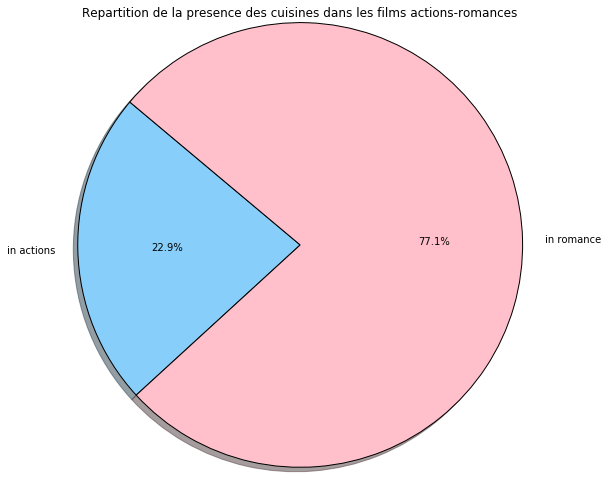

Actions: 22 de présence cuisines
Romances: 74  de présence cuisines


In [39]:
# Data to plot
labels = ["in actions","in romance"]
sizes = [kitchen_count_action, kitchen_count_romance]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition de la presence des cuisines dans les films actions-romances") 
plt.axis('equal')
plt.show()

print('Actions: %s de présence cuisines' %(kitchen_count_action))
print('Romances: %s  de présence cuisines' %(kitchen_count_romance))

In [34]:
kitchen_count_action=0
kitchen_count_romance=0
for df in output_actions:
    kitchen_count_action += find_female_in(df,'kitchen')
for df in output_romances:
    kitchen_count_romance += find_female_in(df,'kitchen')

'gender'
'gender'
'gender'


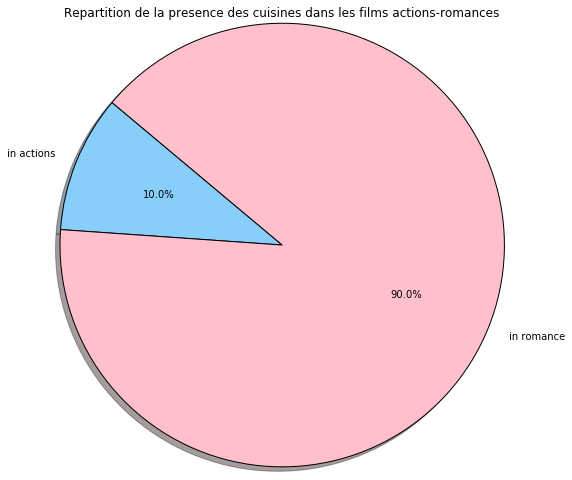

Actions: 1 femmes & cuisines
Romances: 9 femmes & cuisines


In [36]:
# Data to plot
labels = ["in actions","in romance"]
sizes = [kitchen_count_action, kitchen_count_romance]
colors = ['lightskyblue', 'pink']
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Repartition de la presence des cuisines dans les films actions-romances") 
plt.axis('equal')
plt.show()

print('Actions: %s femmes & cuisines' %(kitchen_count_action))
print('Romances: %s femmes & cuisines' %(kitchen_count_romance))